# 예측 결과 출력
* predictionResult 변수에 Str 타입으로 예측결과를 입력해주세요.
* 그 이후 순서대로 실행하시면 됩니다.

순서
1. 이미지 로드(샘플)
2. 예측 결과에서 이미지 로드

In [1]:
import requests
import time
import urllib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import json
import elasticsearch5
import csv
import pickle

# 한글 출력준비

* 네이버 나눔고딕 폰트 등을 설치 또는 사용
* 폰트를 새로 설치 했다면 아래 실행
    ```
    import matplotlib as mpl
    mpl.font_manager._rebuild()
    ```

* 한글 폰트 사용하려면 관련 폰트를 등록하면 된다. (나의 경우는 나눔코딩 폰트)
    ```
    path = 'c:\\windows\\fonts\\nanumgothiccoding.ttf'
    font_name = fm.FontProperties(fname=path, size=50).get_name()
    plt.rc('font', family=font_name)
    ```


In [2]:
path = 'c:\\windows\\fonts\\nanumgothiccoding.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

# Elastic Search 를 이용 (feat 김태경)

In [3]:
es_catetory = elasticsearch5.Elasticsearch('twiceSpark1:9200')
es_preds = elasticsearch5.Elasticsearch('localhost:9200')

In [4]:
def es_category_search(deal_ids):
    res = es_catetory.search(index='ojm5', body={'query': {'ids':{'values':deal_ids}}}, size=100)
    n = res['hits']['total']
    dic = {}
    for hit in res['hits']['hits']:
        dic[hit['_id']] =  hit['_source']
    return dic

In [36]:
def show_one(arch, pred_list):
    img_base_url=r'http://img.wemep.co.kr/'
    
    fig, axes = plt.subplots(ncols=5, figsize=(16,16))    
    s = []
    for i, h in enumerate(pred_list):
        if i == 5: break
        f = urllib.request.urlopen(img_base_url+h[5])
        a = plt.imread(f, format='jpg')
        axes[i].imshow(a)
        s.append("{}/{}".format(h[2], h[3]))
        axes[i].set_title("{}[{}][{}]".format(i, h[1], h[3]))
        axes[i].axis('off')
    print("{}: {}".format(arch, ",".join(s)))
    plt.show()
    

In [44]:
def show_history(hist):
    img_base_url=r'http://img.wemep.co.kr/'
    history = es_category_search(hist)
        
    fig, axes = plt.subplots(ncols=len(hist), figsize=(16,16))
    
    for i, h in enumerate(hist):
        title = history[h]['_2']
        img = history[h]['_3']
        f = urllib.request.urlopen(img_base_url+img)
        a = plt.imread(f, format='jpg')
        axes[i].imshow(a)
        axes[i].set_title("{}".format(title))
        axes[i].axis('off')
    plt.show()

In [46]:
def analyze_preds(user_id):
    img_base_url=r'http://img.wemep.co.kr/'
    
    res = es_preds.search(index='predictions', body={'query': {'term':{'user':user_id}}}, size=100)
    if res['hits']['total'] == 0:
        print('No result find for user {}'.format(user_id))
        return
    
    dic = {}
    history = None
    for i, hit in enumerate(res['hits']['hits']):
        history = hit['_source']['history']
        pred = hit['_source']['pred']
        candidates = list(map(lambda x: x[0], pred))
        res = es_category_search(candidates)
        
        out = []
        for prod, slot, prob in pred:
            if prod in res:
                cat = res[prod]['_4']['_5']
                title = res[prod]['_2']
                img = res[prod]['_3']
                out.append((prod, slot, prob, cat, title, img))
        dic[hit['_source']['arch']] = out

    show_history(history)
    print('above is history')
    for k, h in dic.items():
        show_one(k, h)

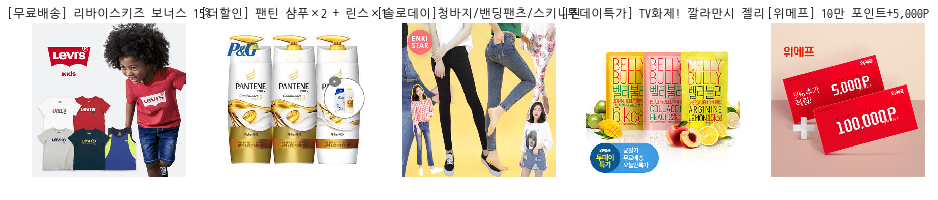

above is history
a32_32_16_eT: 1.00/서랍장,0.98/조리도구,0.98/크림,0.98/빵/베이커리,0.98/펌프스/하이힐


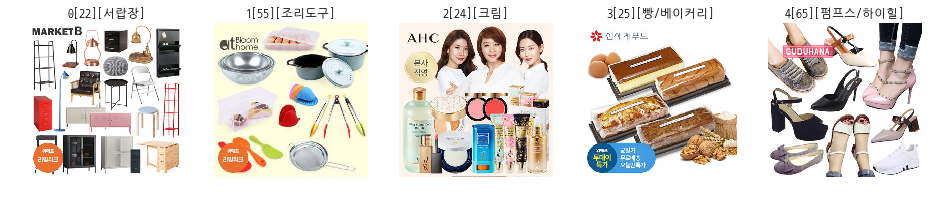

a32_256_256_eF: 0.87/다이어트보조식,0.87/다이어트보조식,0.87/다이어트보조식,0.87/텐트,0.85/통조림/캔


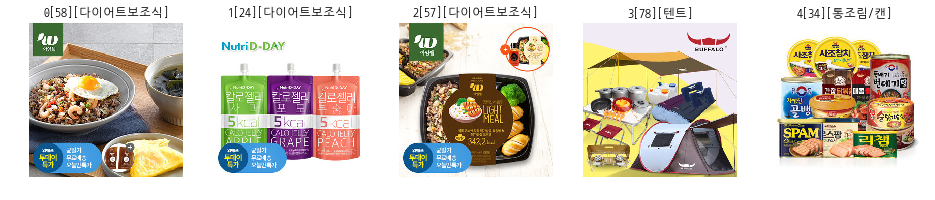

a16_32_16_eT: 0.99/서랍장,0.97/조리도구,0.97/크림,0.97/유아동신발,0.97/빵/베이커리


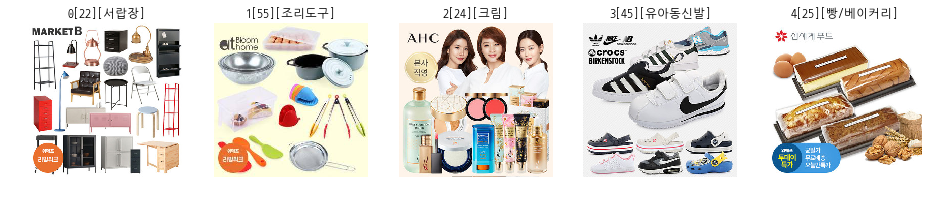

a16_32_16_eF: 0.73/크림,0.73/스킨/로션,0.73/스킨/로션,0.73/냄비,0.73/펌프스/하이힐


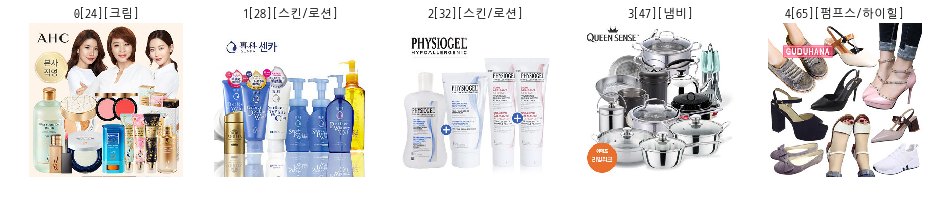

a128_32_16_eT: 0.99/서랍장,0.98/조리도구,0.98/크림,0.98/빵/베이커리,0.98/스킨/로션


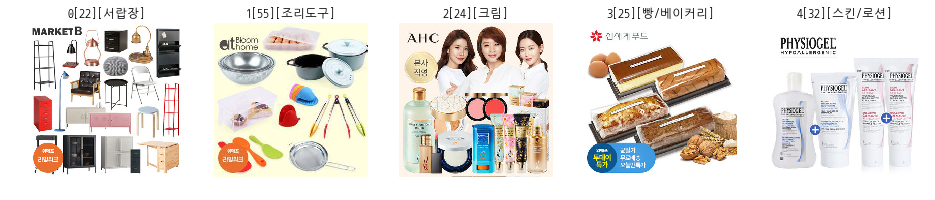

a4_32_16_eT: 0.99/서랍장,0.96/크림,0.96/스킨/로션,0.96/다이어트보조식,0.96/빵/베이커리


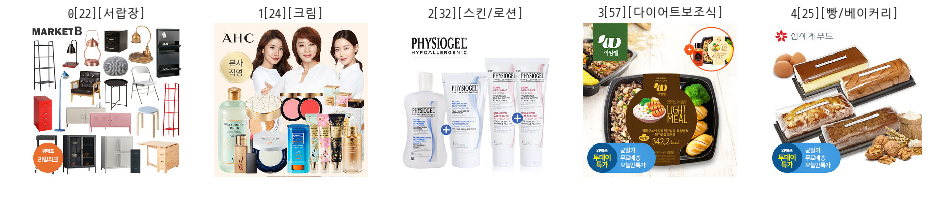

a64_32_16_eT: 1.00/서랍장,0.98/조리도구,0.98/크림,0.98/빵/베이커리,0.98/펌프스/하이힐


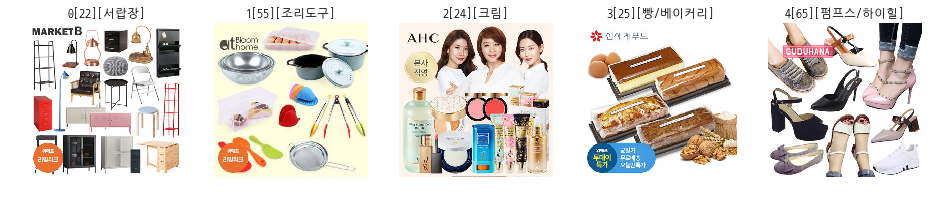

a4_32_16_eF: 0.69/컵,0.69/텐트,0.69/빵/베이커리,0.69/만두/피자/떡볶이,0.69/만두/피자/떡볶이


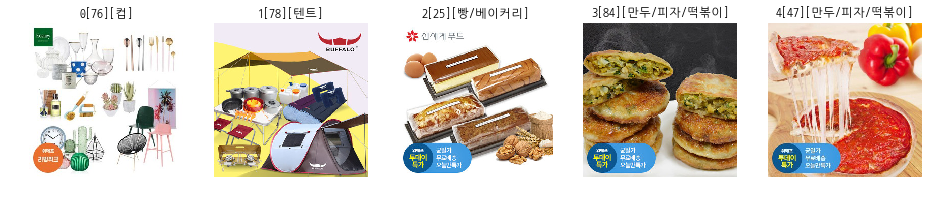

a32_64_64_eF: 0.82/텐트,0.82/다이어트보조식,0.82/다이어트보조식,0.82/다이어트보조식,0.81/컵


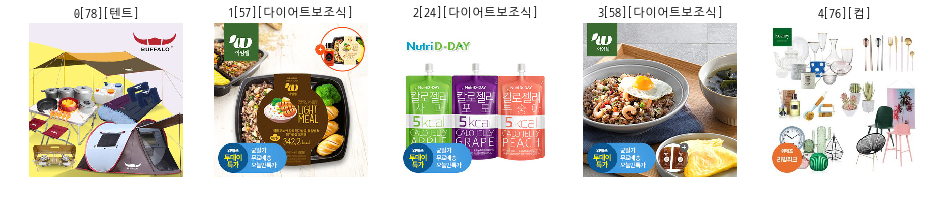

a32_16_16_eF: 0.69/텐트,0.69/컵,0.69/만두/피자/떡볶이,0.69/만두/피자/떡볶이,0.69/김


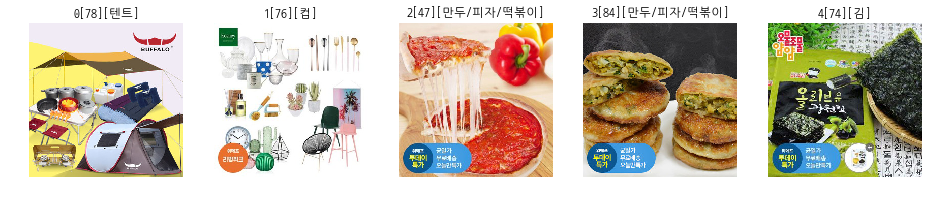

a32_32_16_eF: 0.76/펌프스/하이힐,0.76/펌프스/하이힐,0.76/서랍장,0.76/서랍장,0.76/만두/피자/떡볶이


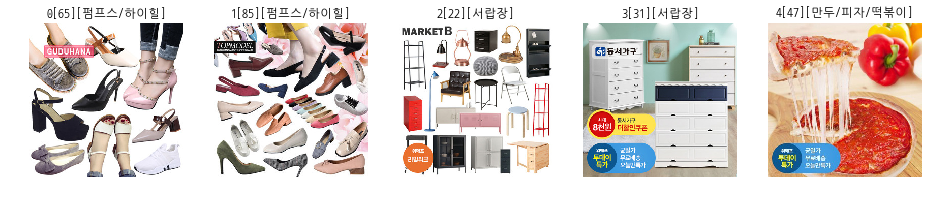

a8_32_16_eF: 0.72/펌프스/하이힐,0.72/펌프스/하이힐,0.72/식기/홈세트,0.72/점퍼/야상,0.72/냄비


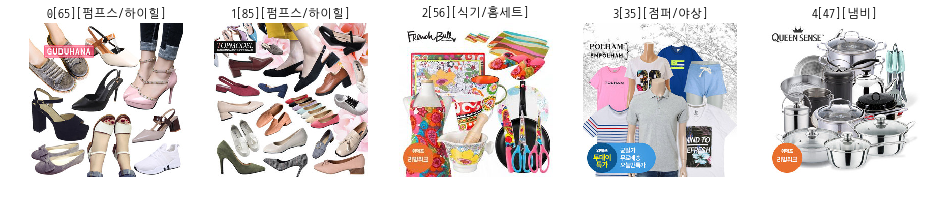

a32_8_8_eF: 0.62/만두/피자/떡볶이,0.62/만두/피자/떡볶이,0.62/텐트,0.62/컵,0.62/서랍장


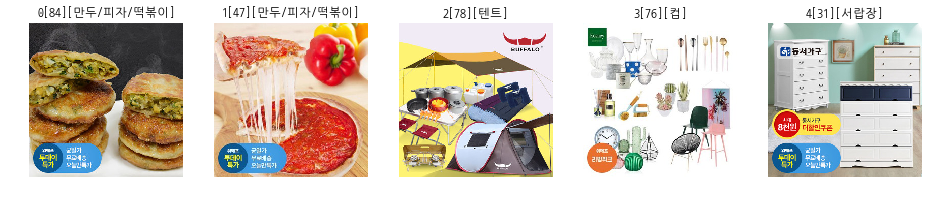

a8_32_16_eT: 0.99/서랍장,0.96/스킨/로션,0.96/청바지/진,0.96/빵/베이커리,0.95/조리도구


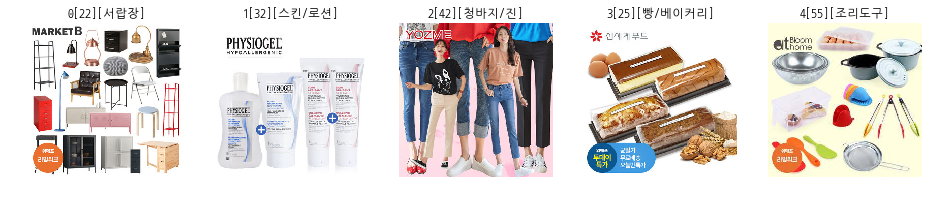

a128_32_16_eF: 0.75/서랍장,0.75/서랍장,0.75/텐트,0.75/크림,0.75/가보시/웨지힐/통굽


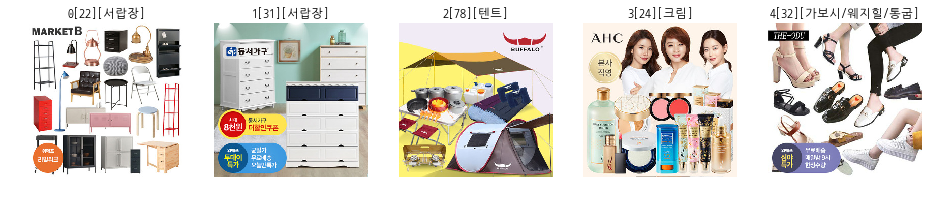

a32_128_128_eF: 0.86/컵,0.84/텐트,0.84/스킨/로션,0.84/스킨/로션,0.83/통조림/캔


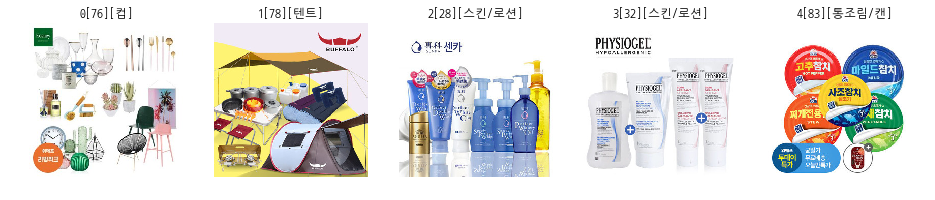

a64_32_16_eF: 0.76/서랍장,0.76/서랍장,0.76/냄비,0.76/가보시/웨지힐/통굽,0.76/컵


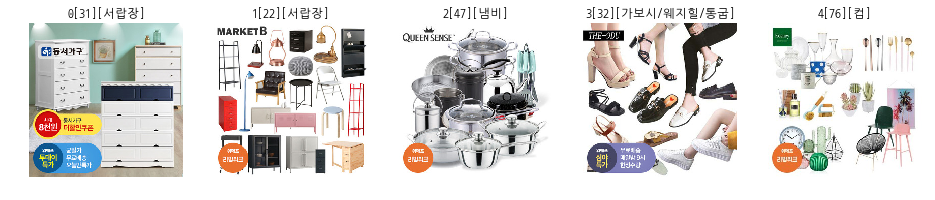

a32_32_32_eF: 0.76/서랍장,0.76/서랍장,0.76/밀폐용기,0.76/텐트,0.76/가보시/웨지힐/통굽


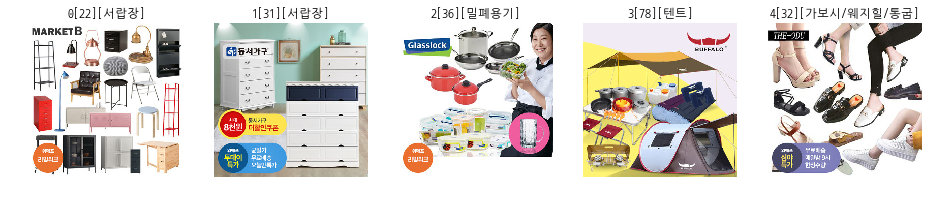

In [47]:
analyze_preds(1000007)